## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

'wget' is not recognized as an internal or external command,
operable program or batch file.


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
# 1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_tdc = pd.read_csv('./data06/data_000637.txt')
data_tdc

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


In [3]:
# 2)
# We know that 30 TDC_MEAS = 1 BX_COUNTER, we want to know the conversion between ORBIT and BX. 
# Statistically we would assume that over the milion entries of the data set the maximum value for BX_COUNTER 
# would occur at least once. So, taking the maximum value for BX +1 it's a safe bet

bx_count = data_tdc['BX_COUNTER'].max() + 1

print(bx_count)

3564


In [4]:
# 3,4) 

data_tdc['ABS_TIME'] = data_tdc.TDC_MEAS*25/30 + data_tdc.BX_COUNTER*25 + data_tdc.ORBIT_CNT*bx_count*25
time_ns = (data_tdc.ABS_TIME.max() - data_tdc.ABS_TIME.min())*10e-9
print(time_ns, 'sec')

9.804162533125 sec


In [5]:
# 5)
distr = np.random.randint(0, 2, data_tdc.shape[0])
data_tdc.HEAD = distr

data_tdc.HEAD

0          0
1          0
2          0
3          1
4          0
          ..
1310715    0
1310716    0
1310717    0
1310718    1
1310719    1
Name: HEAD, Length: 1310720, dtype: int32

In [6]:
# 6)

data_tdc_1 = data_tdc[data_tdc.HEAD == 1]
data_tdc_1.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
3,1,0,64,3869200167,2558,19,3.447457e+14
7,1,0,139,3869200167,2776,0,3.447457e+14
8,1,0,62,3869200167,2774,21,3.447457e+14
10,1,1,7,3869200167,2785,4,3.447457e+14
11,1,0,64,3869200167,2786,19,3.447457e+14


Text(0, 0.5, 'Counts')

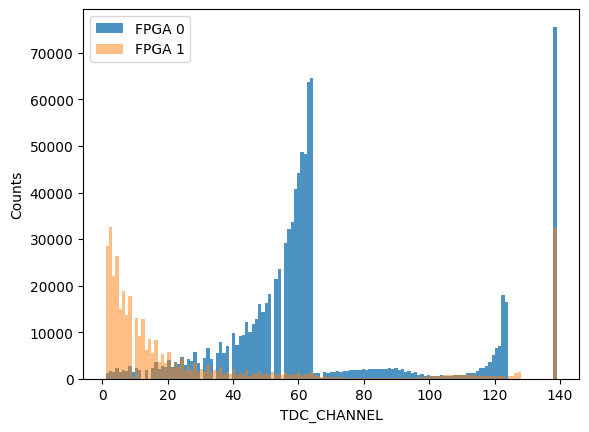

In [10]:
data_tdc[data_tdc.FPGA == 0]['TDC_CHANNEL'].hist(bins=139, label='FPGA 0', alpha=0.8)
data_tdc[data_tdc.FPGA == 1]['TDC_CHANNEL'].hist(bins=139, label='FPGA 1', alpha=0.5)
plt.grid(None)
plt.legend(loc='best')
plt.xlabel('TDC_CHANNEL')
plt.ylabel('Counts')

In [23]:
# 8)

noise_0 = data_tdc[data_tdc.FPGA == 0].groupby(data_tdc.TDC_CHANNEL).size().sort_values(ascending=False)[:3]
noise_1 = data_tdc[data_tdc.FPGA == 1].groupby(data_tdc.TDC_CHANNEL).size().sort_values(ascending=False)[:3]
print('FPGA = 0\n', noise_0)
print('\nFPGA = 1\n', noise_1)

FPGA = 0
 TDC_CHANNEL
139    75617
64     64581
63     63724
dtype: int64

FPGA = 1
 TDC_CHANNEL
2      32669
139    32442
1      28438
dtype: int64


In [32]:
# 9)

uniq_orbit = data_tdc.ORBIT_CNT.nunique()

mask_orbit = data_tdc['TDC_CHANNEL'] == 139

uniq_139 = data_tdc[mask_orbit].ORBIT_CNT.nunique()


print('unique orbit:', uniq_orbit)
print('unique orbit for channel 139:', uniq_139)

unique orbit: 11001
unique orbit for channel 139: 10976
